# Setup

In [ ]:
import os
# Replace 'repo_url' with the URL of the GitHub repository you want to clone
repo_url = 'https://github.com/LIVIAETS/boundary-loss.git'

# Clone the GitHub repository
!git clone $repo_url

# Extract the repository name from the URL
repo_name = repo_url.split('/')[-1].split('.')[0]

# Move into the cloned repository directory
os.chdir(repo_name)

# List the contents of the current directory to verify that the repo has been cloned
!ls

Cloning into 'boundary-loss'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 172 (delta 58), reused 97 (delta 37), pack-reused 39
Receiving objects: 100% (172/172), 463.24 KiB | 4.25 MiB/s, done.
Resolving deltas: 100% (68/68), done.
acdc.make      hist.py	      main.py		   networks.py	release.md    test.py
data	       isles.make     metrics_overtime.py  plot.py	report.py     utils.py
dataloader.py  keras_loss.py  models		   preprocess	resources     viewer
extract.sh     losses.py      moustache.py	   readme.md	scheduler.py  wmh.make


In [ ]:
!pip install medpy

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

from dataloader import dist_map_transform
import torchvision.transforms as transforms
from typing import Any

from utils import probs2one_hot, dice_coef
from losses import GeneralizedDice, BoundaryLoss, FocalLoss, HausdorffLoss, CrossEntropy
from tqdm import tqdm

In [ ]:
figures_path = Path('figures')
figures_path.mkdir(exist_ok='True')

# DRIVE dataset
2D RGB images to evaluate the method on new dataset.
https://drive.grand-challenge.org/

18 training data and 2 validation data

Possible inconveniences : only 20 images

In [ ]:
def get_data():
    !gdown --fuzzy url -O 'data/'
    !gdown --fuzzy url -O 'data/'
    if Path("data/test.zip").exists() and Path("data/training.zip").exists():
      !unzip 'data/test.zip' -d 'data/'
      !unzip 'data/training.zip' -d 'data/'
    else :
      print('Some of the data cannot be downloaded !')

    path_to_training_data = Path("data/training/")
    path_to_test_data = Path("data/test/")

    images_path = sorted(glob.glob(os.path.join(path_to_training_data, 'images', '*')))
    mask_path = sorted(glob.glob(os.path.join(path_to_training_data, 'mask', '*')))
    gt_path = sorted(glob.glob(os.path.join(path_to_training_data, '1st_manual', '*')))
    return images_path, mask_path, gt_path


In [ ]:
images_path, mask_path, gt_path = get_data()

# --- data augmentation ------
nb_val = 2
val_images_path = images_path[-2:]
val_gt_path = gt_path[-2:]

train_images_path = images_path[:-2] #*2
train_gt_path = gt_path[:-2] #*2
nb_train = len(train_images_path)

Downloading...
From: https://drive.google.com/uc?id=1s3SINN2K6NEcNh-tOuuCKxCdg7ABYbD9
To: /content/boundary-loss/boundary-loss/data/training.zip
100% 14.8M/14.8M [00:00<00:00, 66.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fU49fNkotiHwPNqDzIIyWtsiPElGmHaL
To: /content/boundary-loss/boundary-loss/data/test.zip
100% 14.6M/14.6M [00:00<00:00, 44.7MB/s]
Archive:  data/test.zip
   creating: data/test/
   creating: data/test/images/
  inflating: data/test/images/01_test.tif  
  inflating: data/test/images/02_test.tif  
  inflating: data/test/images/03_test.tif  
  inflating: data/test/images/04_test.tif  
  inflating: data/test/images/05_test.tif  
  inflating: data/test/images/06_test.tif  
  inflating: data/test/images/07_test.tif  
  inflating: data/test/images/08_test.tif  
  inflating: data/test/images/09_test.tif  
  inflating: data/test/images/10_test.tif  
  inflating: data/test/images/11_test.tif  
  inflating: data/test/images/12_test.tif  
  inflating: data/test/im

In [ ]:
# Exploration of the data

print(f"nb of training images: {nb_train}")

nb of training images: 18


In [ ]:
# fig, axs = plt.subplots(2, 3)

# for i in range(3):
#   rd_id = np.random.randint(0, nb_train)

#   im = Image.open(train_images_path[rd_id])
#   im=np.array(im)
#   axs[0, i].imshow(im)
#   axs[0, i].axis('off')
#   axs[0, i].set_title(f"Image {im.shape}", fontsize=10)


#   gt = np.array(Image.open(train_gt_path[rd_id]))
#   print(f"gt unique {np.unique(gt)}")
#   axs[1, i].imshow(gt, cmap='gray')
#   axs[1, i].axis('off')
#   axs[1, i].set_title(f"segmentation {gt.shape}", fontsize=10)

#   fig.tight_layout()

#   fig.savefig(figures_path / "ex_drive.png")


## Create dataset and dataloader

In [ ]:
def min_max_normalization(inp: torch.tensor) -> torch.tensor:
  return (inp - inp.min()) / (inp.max() - inp.min())

def crop_tensor(inp: torch.tensor, crop_start: int=0, crop_end: int=-1) -> torch.tensor:

  return inp[..., crop_start:crop_end]

def crop_to_power_of_two(tensor):
  shape = np.array(tensor.shape)

  new_size = 2** np.floor( np.log2( shape[-2:]))

  mid = shape[-2:]/2

  cropped_tensor = tensor[..., int(mid[0] - new_size[0]/2): int(mid[0] + new_size[0]/2), int(mid[1] - new_size[1]/2): int(mid[1] + new_size[1]/2)]

  return cropped_tensor

def downsample2D(inp: torch.tensor, scale : float = (.5, .5)) -> torch.tensor:
  if len(inp.shape) == 3:
    inp = inp.unsqueeze(0)
  if len(inp.shape) ==2:
    inp = inp.unsqueeze(0).unsqueeze(0)

  out = F.interpolate(inp, size=None, scale_factor=scale, mode='nearest').squeeze()
  return out


In [ ]:
transform_IMG = transforms.Compose([
    transforms.PILToTensor(),
    min_max_normalization,
    downsample2D,
    crop_to_power_of_two,
    transforms.RandomHorizontalFlip()
])

class DriveDataset(Dataset):
    def __init__(self, img_filenames: list[str],
                 gt_filenames: list[str] = None,
                 transform: Any = transform_IMG):

        self.img_filenames = img_filenames  # You get the list as you would usually
        self.gt_filenames = gt_filenames # Path to the root of the data
        self.transform = transform
        self.disttransform = dist_map_transform([1, 1], 2) # instantiate a distance transform for a binary setting, with 1mm on each axis

    def __len__(self):
      return len(self.img_filenames)

    def __getitem__(self, index: int) -> dict[str, torch.tensor]:

        image = Image.open(self.img_filenames[index])
        state = torch.get_rng_state()
        image_tensor =  self.transform(image) # usual transform for an image

        if self.gt_filenames:
          label = Image.open(self.gt_filenames[index])
          torch.set_rng_state(state)
          one_hot_tensor = self.transform(label)  # Usualy transform from png to one_hot encoding
          one_hot_tensor = torch.squeeze(one_hot_tensor).int() # (H, W)

          dist_map_tensor: torch.tensor = self.disttransform(one_hot_tensor)

        else:
          one_hot_tensor = None
          dist_map_tensor = None

        return {"images": image_tensor,
                "gt": one_hot_tensor,
                "dist_map": dist_map_tensor}

In [ ]:
def show_tensor(ax, tensor, title='Image'):
  # tensor = min_max_normalization(tensor)*255

  if tensor.dim() == 4:
    tensor = tensor.squeeze()
  else:
    pass

  if tensor.dim() == 2:
    im = ax.imshow(tensor, cmap='gray')
  else :

    if tensor.shape[-1] > 3:
      tensor = tensor.permute(1, 2, 0)
    else:
      pass

    if tensor.shape[-1] == 1:
      im = ax.imshow(tensor, cmap='gray')

    if tensor.shape[-1] == 3:
      im = ax.imshow(tensor)

  ax.set_title(title)
  return im


def show_diff(ax, tensor, seg_map, title='diff'):
  mask = np.tile(seg_map, (1, 3, 1, 1) )
  superpos = tensor - mask

  show_tensor(ax, superpos, title=title)

## Example tests

In [ ]:
data = DriveDataset(train_images_path, train_gt_path)


In [ ]:
len(data)

18

In [ ]:
d = data[9]
print('image shape ', d['images'].shape)
print('gt shape ', d['gt'].shape)
print('dist_map ', d['dist_map'].shape)

image shape  torch.Size([3, 256, 256])
gt shape  torch.Size([256, 256])
dist_map  torch.Size([2, 256, 256])


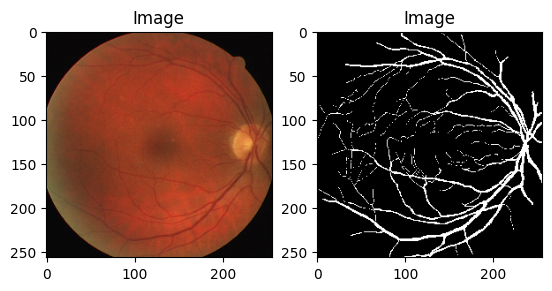

In [ ]:
# Test random flip
fig, ax = plt.subplots(1, 2)
show_tensor(ax[0], d['images'])
show_tensor(ax[1], d['gt'])

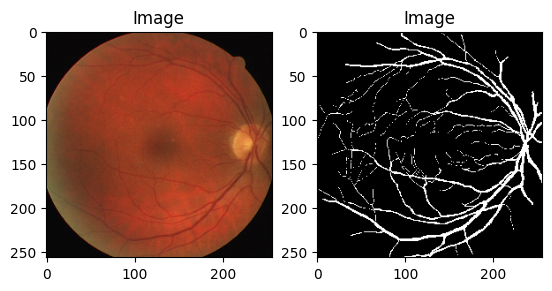

In [ ]:


state = torch.get_rng_state()
img = transforms.RandomHorizontalFlip()(d['images'])
torch.set_rng_state(state)
target = transforms.RandomHorizontalFlip()(d['gt'])


fig, ax = plt.subplots(1, 2)

show_tensor(ax[0], img)
show_tensor(ax[1], target)

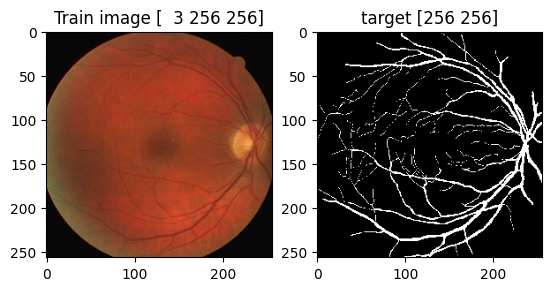

TypeError: ignored

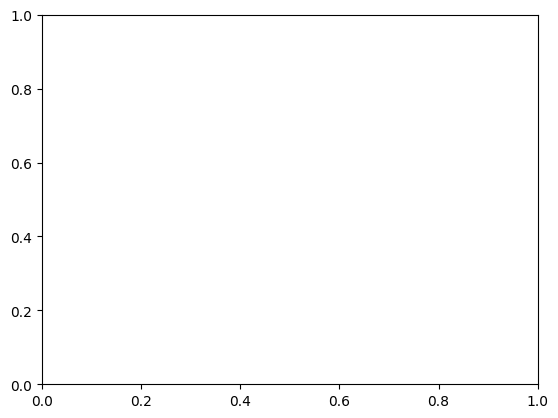

In [ ]:
fig, axs = plt.subplots(1, 2)
im = d['images']
gt = d['gt']
seg_map = gt.unsqueeze(0).unsqueeze(0)
_ = show_tensor(axs[0], im, title=f'Train image {np.array(im.shape)}')
im = show_tensor(axs[1], seg_map, title=f'target {np.array(gt.size())}')

plt.show()

fig, ax = plt.subplots()
show_diff(ax, d['images'], seg_map, title=f'seg {seg_map.shape}')

In [ ]:
fig, axs = plt.subplots(2, 3)

for i in range(3):
  rd_id = np.random.randint(0, nb_train)

  d = data[rd_id]
  im = d['images']

  show_tensor(axs[0, i], im)
  axs[0, i].axis('off')
  axs[0, i].set_title(f"Train Image", fontsize=10)


  gt = d['gt']
  show_tensor(axs[1, i], gt)
  axs[1, i].axis('off')
  axs[1, i].set_title(f"Target segmentation", fontsize=10)

fig.tight_layout()

fig.savefig(figures_path / "ex_drive.png")

In [ ]:
fig, ax = plt.subplots()
show_tensor(ax, d['images'], title='')
ax.axis('off')
fig.savefig(figures_path / 'ex_dist1')

fig, ax = plt.subplots()
show_tensor(ax, d['gt'], title='')
ax.axis('off')
fig.savefig(figures_path / 'ex_dist2')

In [ ]:
fig, ax = plt.subplots(1, 2, width_ratios = [1, 0.04])

im = show_tensor(ax[0], d['dist_map'][0], title="Distance map to the background")
ax[0].axis('off')
fig.colorbar(im, cax=ax[-1], orientation='vertical')
fig.tight_layout()

fig.savefig(figures_path / 'ex_dist3.png')


In [ ]:
fig, ax = plt.subplots(1, 2, width_ratios = [1, 0.04])

im = show_tensor(ax[0], d['dist_map'][1], title="Distance map to the foreground")
ax[0].axis('off')
fig.colorbar(im, cax=ax[-1], orientation='vertical')
fig.tight_layout()

fig.savefig(figures_path / 'ex_dist4')


# Train on DRIVE data

*Remarks* : The softmax function essentially normalizes the input vector into a probability distribution, ensuring that the output values sum to 1. The exponentiation of the logits (exponential function) in the numerator gives higher values more weight, making the largest logit dominate the probability distribution.

The temperature parameter can be introduced to control the level of randomness in the output probabilities.

When the temperature is high, the softmax function becomes more uniform, and the model is more uncertain about its predictions. On the other hand, when the temperature is low, the softmax function tends to concentrate more on the class with the highest logit, making the model more confident in its predictions.

In [ ]:
def setup( list_loss_weights: list[int],
           modalities: int = 3,
           n_class: int = 2,
           network: str = 'UNet',
           regional_loss_type = GeneralizedDice,
           with_bl: bool = True,
           use_sgd: bool = False,
           l_rate: float = 5e-4):

  cpu: bool = not torch.cuda.is_available()
  device = torch.device("cpu") if cpu else torch.device("cuda")

  net_class = getattr(__import__('networks'), network)
  net = net_class(modalities, n_class).to(device)
  net.init_weights()
  net.to(device)

  optimizer: Any  # disable an error for the optmizer (ADAM and SGD not same type)
  if use_sgd:
          optimizer = torch.optim.SGD(net.parameters(), lr=l_rate, momentum=0.99, weight_decay=5e-4)
  else:
          optimizer = torch.optim.Adam(net.parameters(), lr=l_rate, betas=(0.9, 0.99), amsgrad=False)

  regional_loss = regional_loss_type(idc=[0, 1])  # add here the extra params for the losses
  if with_bl:
    boundary_loss = BoundaryLoss(idc=[1]) # idc is used to filter out some classes of the target mask
  else:
    boundary_loss = None

  losses_dict = {
      'regular_loss' : regional_loss,
      'boundary_loss' : boundary_loss,
      'weight_regular_loss': list_loss_weights[0],
      'weight_boundary_loss': list_loss_weights[1]
  }

  return net, optimizer, device, losses_dict




In [ ]:
# from utils import one_hot, simplex, sset

def do_epoch(dataloader: DataLoader, model: Any, losses_dict : dict,
                device: Any,
                optimizer: Any = None,
                mode : str = "train", temperature: float=1.0) -> tuple[torch.tensor, torch.tensor]:

    log_regular_loss, log_bl_loss, log_total_loss, log_dsc = [], [], [], []

    if mode == "train":
      model.train(True) # inform layer such as BatchNorm and Dropout that the model is trianing (not the case here)
    elif mode == "val":
      model.eval()

    for data in dataloader:

      image: torch.tensor = data["images"].to(device)
      target: torch.tensor = data["gt"]
      dist_map_label: list[torch.tensor] = data["dist_map"].to(device)

      if mode ==" val":
        print(f"mode {mode} : data {len(data)}")
        print(f"image {image.shape}")

      assert not target.requires_grad # target should be optimized , appear on the compute graph

      if optimizer:
        optimizer.zero_grad() # reset gradients

      # Forward
      # print('\nForward------')
      pred_logits = model(image)
      pred_probs = F.softmax(pred_logits / temperature, dim=1) # softmax will be computed along axis 1

      label = torch.stack((1 - target, target), dim=1).to(device)

      # compute loss
      # print('compute regular loss')
      regular_loss = losses_dict['regular_loss'](pred_probs, label)
      total_loss = losses_dict['weight_regular_loss']*regular_loss

      if losses_dict['boundary_loss']:
        bl_loss = losses_dict['boundary_loss'](pred_probs, dist_map_label)  # Notice we do not give the same input to that loss
        total_loss += losses_dict['weight_boundary_loss'] * bl_loss
        log_bl_loss.append(bl_loss.item())

      # print(f"weight losses reg :{losses_dict['weight_regular_loss']}, bd {losses_dict['weight_boundary_loss']}")
      # print(f"reg loss : {regular_loss}")
      # print('backward ----')

      if optimizer :
        total_loss.backward()
        optimizer.step()

      # Compute metrics
      predicted_mask = probs2one_hot(pred_probs.detach())  # Used only for dice computation
      assert not predicted_mask.requires_grad
      # print(f"\nmode {mode} predicted_mask {predicted_mask.shape}")
      # print(f"mode {mode} label {label.shape}")

      dice = dice_coef(label.cpu(), predicted_mask.cpu()) # dice batch

      # Compute and log metrics
      log_regular_loss.append(regular_loss.item())
      log_total_loss.append(total_loss.item())
      log_dsc += dice.tolist()

    return log_regular_loss, log_bl_loss, log_total_loss, log_dsc


In [ ]:
def plot_learning_curve(train_log : dict, val_log : dict,
                        reg_loss_name : str = 'Generalized Dice',
                        with_bl : bool = True,
                        fig_folder : str = figures_path,
                        exp_title : str = 'wBL'):

  losses = ['total_loss', 'regular_loss']

  if with_bl:
    losses += ['bl_loss']

  fig, ax = plt.subplots(2, len(losses), figsize=(10, 5))

  for i, loss in enumerate(losses):
    if 'regular' in loss:
      title = reg_loss_name
    else:
      title = loss

    ax[0, i].plot(train_log[loss])
    ax[0, i].set_xlabel('Iteration')
    ax[0, i].set_title(f'Train {title}')

    ax[1, i].plot(val_log[loss])
    ax[1, i].set_xlabel('Iteration')
    ax[1, i].set_title(f'Val {title}')

  fig.tight_layout()
  fig.savefig(fig_folder / f'{exp_title}_learning_curves.png')

  # plot dice score
  fig2, ax2 = plt.subplots(1, 2, figsize = (10, 5))

  train_dsc = np.array(train_log['dsc']).T
  val_dsc = np.array(val_log['dsc']).T

  ax2[0].plot(train_dsc[0], label='Dice with background')
  ax2[0].plot(train_dsc[1], label='Dice with foreground')
  ax2[0].set_title('Train Dice Score')
  ax2[0].legend()
  ax2[1].plot(val_dsc[0], label='Dice with background')
  ax2[1].plot(val_dsc[1], label='Dice with foreground')
  ax2[1].set_title("Val Dice Score")
  ax2[1].legend()

  fig2.savefig(fig_folder / f'{exp_title}_dice_coeff_training.png')


In [ ]:
def predict(net : torch.nn.Module, inp : torch.tensor) -> torch.tensor:
  device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

  net.eval()
  pred_logits = net(inp.to(device)).cpu()
  pred_probs = F.softmax(pred_logits, dim=1)
  _, segmentation_map = torch.max(pred_probs.squeeze(), dim=0)

  return segmentation_map

In [ ]:
test_image_path = sorted(glob.glob("data/test/images/*.tif"))
nb_test = len(test_image_path)
test_dataset = DriveDataset(test_image_path)

def plot_test_result(net, test_dataset, nb_test:int=nb_test,
                     exp_title : str = 'GDLwBL',
                     figure_folder = figures_path):
  fig, ax = plt.subplots(2, 3)

  for i in range(ax.shape[1]):
    indx = torch.randint(nb_test, (1,))
    d = test_dataset[indx]
    inp = d['images'].unsqueeze(0)
    target = d['gt']

    segmentation_map = predict(net, inp)

    show_tensor(ax[0, i], d['images'], title=f'Test image')
    show_tensor(ax[1, i], segmentation_map, title=f" Predicted segmentation")
    ax[0, i].axis('off')
    ax[1, i].axis('off')

  fig.tight_layout()
  fig.savefig(figure_folder / f"results_on_test{exp_title}.png")

## EXP GDL + BL

In [ ]:
def training(n_epochs: int = 100, batch_size: int =1):

  train_log = { 'regular_loss': [], 'bl_loss': [], 'total_loss': [], 'dsc' : []}
  val_log = { 'regular_loss': [], 'bl_loss': [], 'total_loss': [], 'dsc' : []}
  net, optimizer, device, loss_dict = setup(list_loss_weights=[1, 0.05], network='UNet',
                                            regional_loss_type=GeneralizedDice,
                                            with_bl=True)

  train_dataset = DriveDataset(train_images_path, train_gt_path)
  val_dataset = DriveDataset(val_images_path, val_gt_path)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

  for epoch in tqdm(range(n_epochs)):

    log_regular_loss, log_bl_loss, log_total_loss, log_dsc = do_epoch(train_dataloader,
                                                                      net, loss_dict,
                                                                      device,
                                                                      optimizer=optimizer,
                                                                      mode = "train")


    train_log['regular_loss'] += log_regular_loss
    train_log['bl_loss'] += log_bl_loss
    train_log['total_loss'] += log_total_loss
    train_log['dsc'] += log_dsc

    with torch.no_grad(): # disable gradient computation, reduce memory
      log_regular_loss, log_bl_loss, log_total_loss, log_dsc = do_epoch(val_dataloader,
                                                                        net, loss_dict, device,
                                                                        mode="val")


      val_log['regular_loss'] += log_regular_loss
      val_log['bl_loss'] += log_bl_loss
      val_log['total_loss'] += log_total_loss
      val_log['dsc'] += log_dsc

  return net, train_log, val_log


In [ ]:
train_net, train_log, val_log = training(n_epochs=150, batch_size=8)

Initialized GeneralizedDice with {'idc': [0, 1]}
Initialized SurfaceLoss with {'idc': [1]}


100%|██████████| 150/150 [08:47<00:00,  3.52s/it]


In [ ]:
torch.save(train_net.state_dict(), Path('Unet_GDL_05BL'))

In [ ]:
val_dsc = np.array(val_log['dsc']).T
val_dsc[:, -1]

array([0.9754141 , 0.78845167])

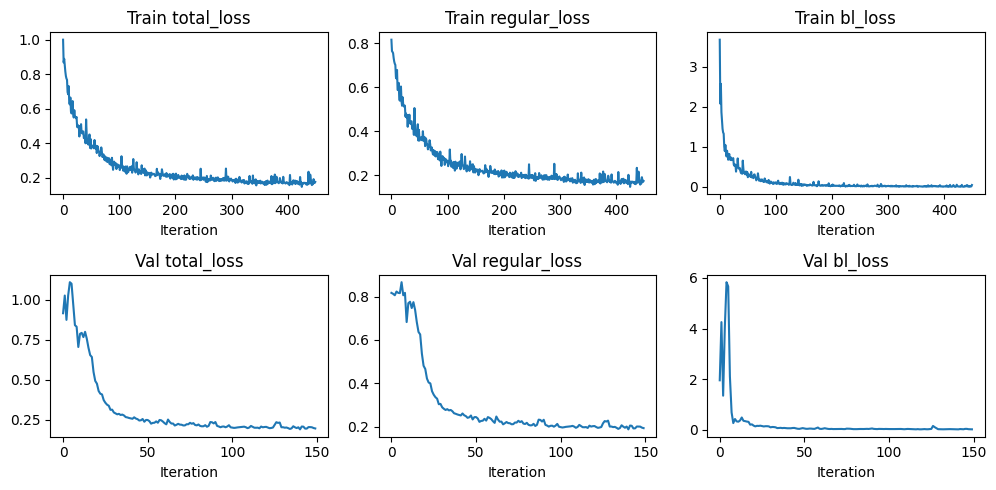

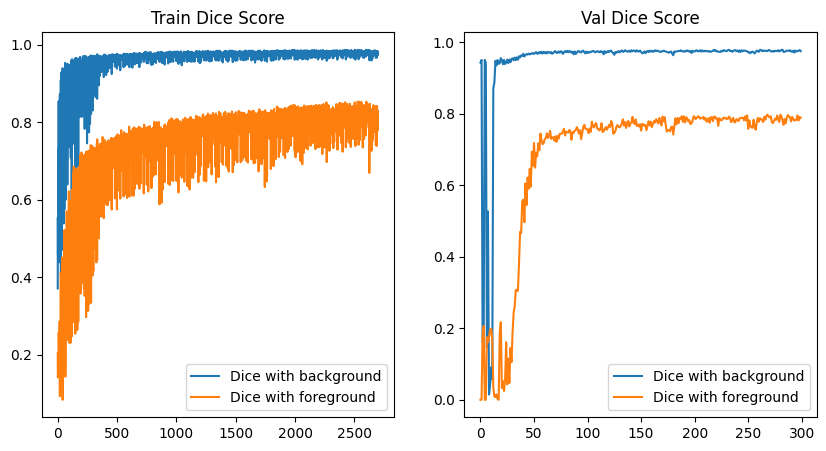

In [ ]:
plot_learning_curve(train_log, val_log)

In [ ]:
data = DriveDataset(train_images_path, train_gt_path)

tensor([16])
tensor([8])


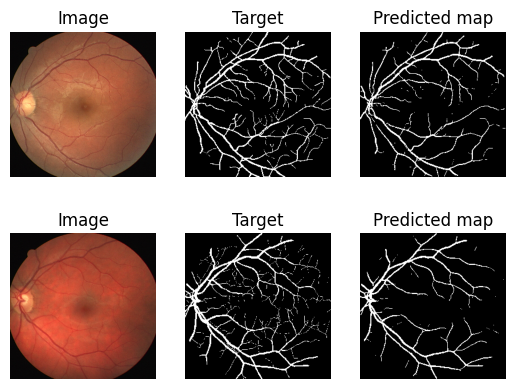

In [ ]:
fig, axs = plt.subplots(2, 3)

for i in range(2):
  indx = torch.randint(nb_train, (1,))
  d = data[indx]
  inp = d['images'].unsqueeze(0)
  target = d['gt']

  show_tensor(axs[i, 0], inp)
  axs[i, 0].set_title('Image')
  axs[i, 0].axis('off')

  axs[i, 1].imshow(target, cmap='gray')
  axs[i, 1].set_title('Target')
  axs[i, 1].axis('off')

  segmentation_map = predict(train_net, inp)
  show_tensor(axs[i, 2], segmentation_map)
  axs[i, 2].set_title('Predicted map')
  axs[i, 2].axis('off')


fig.savefig(figures_path / 'results_on_train.png')

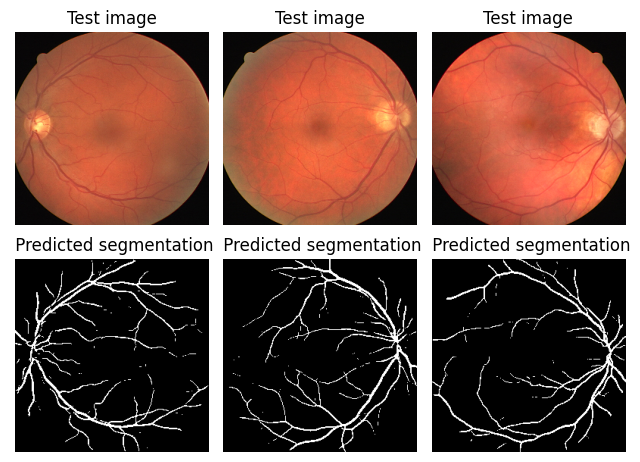

In [ ]:
test_image_path = sorted(glob.glob("data/test/images/*.tif"))
nb_test = len(test_image_path)
test_dataset = DriveDataset(test_image_path)

fig, ax = plt.subplots(2, 3)

for i in range(ax.shape[1]):
  indx = torch.randint(nb_test, (1,))
  d = test_dataset[indx]
  inp = d['images'].unsqueeze(0)
  target = d['gt']

  segmentation_map = predict(train_net, inp)

  show_tensor(ax[0, i], d['images'], title=f'Test image')
  show_tensor(ax[1, i], segmentation_map, title=f" Predicted segmentation")
  ax[0, i].axis('off')
  ax[1, i].axis('off')

fig.tight_layout()
fig.savefig(figures_path / "result_on_test.png")

## EXP CE + BL

In [ ]:
def training_4(n_epochs: int = 100, batch_size: int =1):

  train_log = { 'regular_loss': [], 'bl_loss': [], 'total_loss': [], 'dsc' : []}
  val_log = { 'regular_loss': [], 'bl_loss': [], 'total_loss': [], 'dsc' : []}
  net, optimizer, device, loss_dict = setup(list_loss_weights=[1., 0.05], network='UNet',
                                            regional_loss_type=CrossEntropy,
                                            with_bl=True)

  train_dataset = DriveDataset(train_images_path, train_gt_path)
  val_dataset = DriveDataset(val_images_path, val_gt_path)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

  for epoch in tqdm(range(n_epochs)):

    log_regular_loss, log_bl_loss, log_total_loss, log_dsc = do_epoch(train_dataloader,
                                                                      net, loss_dict,
                                                                      device,
                                                                      optimizer=optimizer,
                                                                      mode = "train")


    train_log['regular_loss'] += log_regular_loss
    train_log['bl_loss'] += log_bl_loss
    train_log['total_loss'] += log_total_loss
    train_log['dsc'] += log_dsc

    with torch.no_grad(): # disable gradient computation, reduce memory
      log_regular_loss, log_bl_loss, log_total_loss, log_dsc = do_epoch(val_dataloader,
                                                                        net, loss_dict, device,
                                                                        mode="val")


      val_log['regular_loss'] += log_regular_loss
      val_log['bl_loss'] += log_bl_loss
      val_log['total_loss'] += log_total_loss
      val_log['dsc'] += log_dsc

  return net, train_log, val_log

train_net_4, train_log_4, val_log_4 = training_4(n_epochs=150, batch_size=8)

Initialized CrossEntropy with {'idc': [0, 1]}
Initialized SurfaceLoss with {'idc': [1]}


100%|██████████| 150/150 [09:03<00:00,  3.62s/it]


In [ ]:
torch.save(train_net_4, Path('Unet_4'))
print(f"Model 4 final DSC : {val_log_4['dsc'][-1]}")

Model 4 final DSC : [0.9750539660453796, 0.7632842659950256]


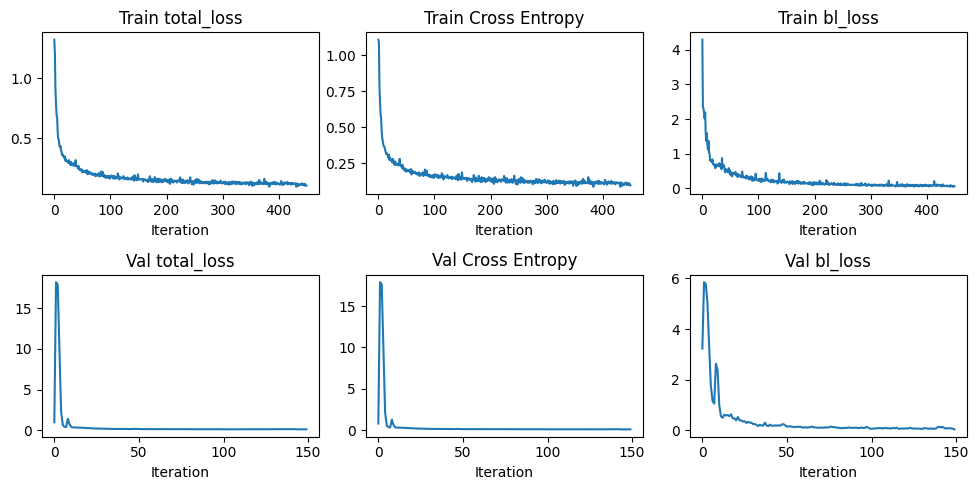

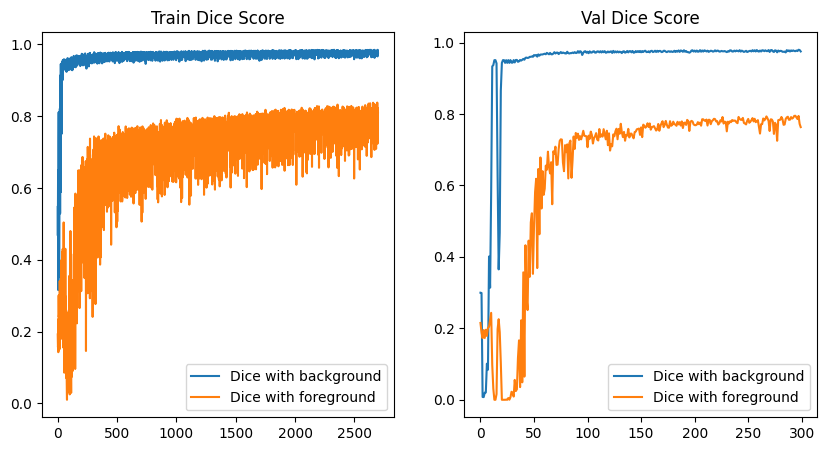

In [ ]:
plot_learning_curve(train_log_4, val_log_4,
                        reg_loss_name = 'Cross Entropy',
                        with_bl = True,
                        exp_title='CEwBL')

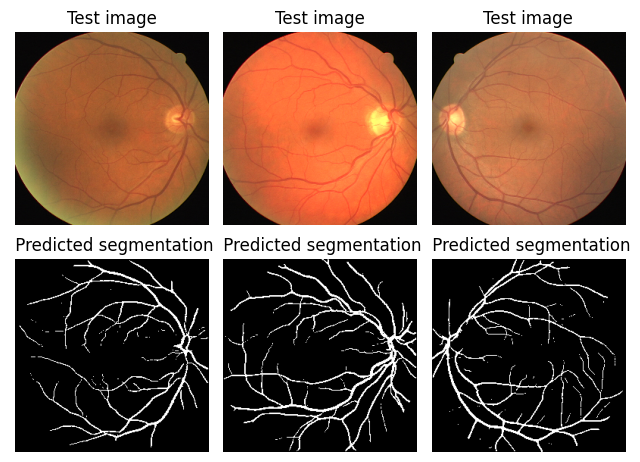

In [ ]:
plot_test_result(train_net_4, test_dataset, nb_test, exp_title='CEwBL')

## Experiments CE

In [ ]:
def training_cross_entropy(n_epochs: int = 100, batch_size: int =1):

  train_log = { 'regular_loss': [], 'bl_loss': [], 'total_loss': [], 'dsc' : []}
  val_log = { 'regular_loss': [], 'bl_loss': [], 'total_loss': [], 'dsc' : []}
  net, optimizer, device, loss_dict = setup(list_loss_weights=[1., 0.], network='UNet',
                                            regional_loss_type=CrossEntropy,
                                            with_bl=False)

  train_dataset = DriveDataset(train_images_path, train_gt_path)
  val_dataset = DriveDataset(val_images_path, val_gt_path)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

  for epoch in tqdm(range(n_epochs)):

    log_regular_loss, log_bl_loss, log_total_loss, log_dsc = do_epoch(train_dataloader,
                                                                      net, loss_dict,
                                                                      device,
                                                                      optimizer=optimizer,
                                                                      mode = "train")


    train_log['regular_loss'] += log_regular_loss
    train_log['bl_loss'] += log_bl_loss
    train_log['total_loss'] += log_total_loss
    train_log['dsc'] += log_dsc

    with torch.no_grad(): # disable gradient computation, reduce memory
      log_regular_loss, log_bl_loss, log_total_loss, log_dsc = do_epoch(val_dataloader,
                                                                        net, loss_dict, device,
                                                                        mode="val")


      val_log['regular_loss'] += log_regular_loss
      val_log['bl_loss'] += log_bl_loss
      val_log['total_loss'] += log_total_loss
      val_log['dsc'] += log_dsc

  return net, train_log, val_log


In [ ]:
train_CE_net, CE_train_log, CE_val_log = training_cross_entropy(n_epochs=150, batch_size=8)

Initialized CrossEntropy with {'idc': [0, 1]}


100%|██████████| 150/150 [08:49<00:00,  3.53s/it]


In [ ]:
torch.save(train_CE_net, Path('Unet_CE'))

In [ ]:
print(f"CE final DSC : {CE_val_log['dsc'][-1]}")

CE final DSC : [0.975774347782135, 0.797515332698822]


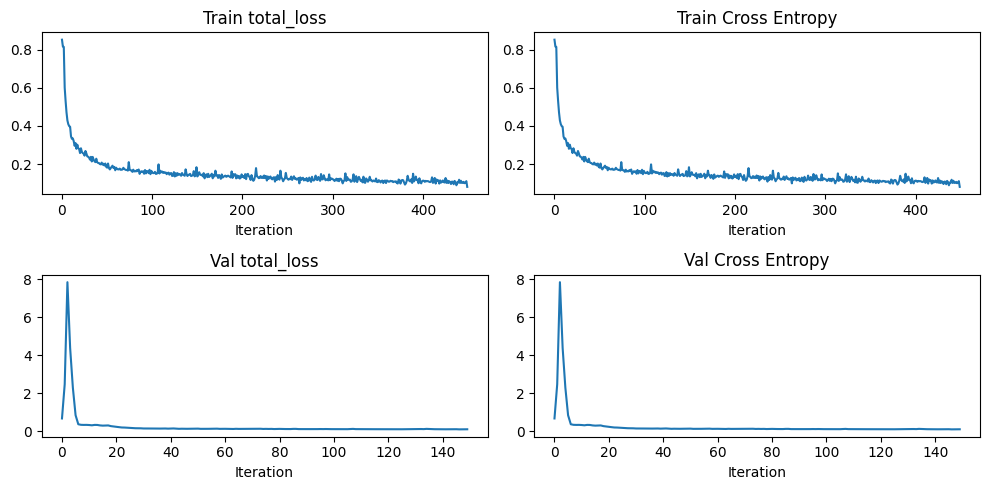

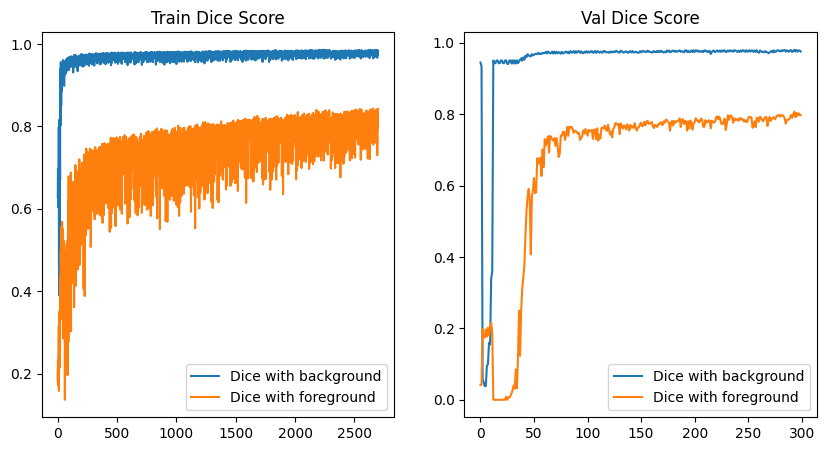

In [ ]:
plot_learning_curve(CE_train_log, CE_val_log,
                        reg_loss_name = 'Cross Entropy',
                        with_bl = False,
                        exp_title='CE')

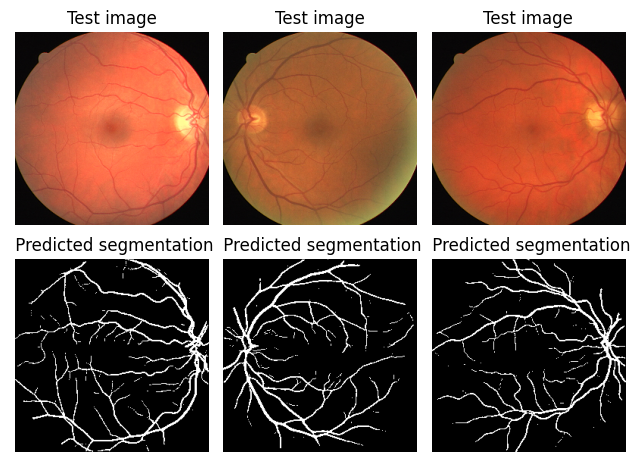

In [ ]:
plot_test_result(train_CE_net, test_dataset, exp_title='CE')

## EXP GDL

In [ ]:
def training_GDL(n_epochs: int = 100, batch_size: int =1):

  train_log = { 'regular_loss': [], 'bl_loss': [], 'total_loss': [], 'dsc' : []}
  val_log = { 'regular_loss': [], 'bl_loss': [], 'total_loss': [], 'dsc' : []}
  net, optimizer, device, loss_dict = setup(list_loss_weights=[1., 0.], network='UNet',
                                            regional_loss_type=GeneralizedDice,
                                            with_bl=False)

  train_dataset = DriveDataset(train_images_path, train_gt_path)
  val_dataset = DriveDataset(val_images_path, val_gt_path)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

  for epoch in tqdm(range(n_epochs)):

    log_regular_loss, log_bl_loss, log_total_loss, log_dsc = do_epoch(train_dataloader,
                                                                      net, loss_dict,
                                                                      device,
                                                                      optimizer=optimizer,
                                                                      mode = "train")


    train_log['regular_loss'] += log_regular_loss
    train_log['bl_loss'] += log_bl_loss
    train_log['total_loss'] += log_total_loss
    train_log['dsc'] += log_dsc

    with torch.no_grad(): # disable gradient computation, reduce memory
      log_regular_loss, log_bl_loss, log_total_loss, log_dsc = do_epoch(val_dataloader,
                                                                        net, loss_dict, device,
                                                                        mode="val")


      val_log['regular_loss'] += log_regular_loss
      val_log['bl_loss'] += log_bl_loss
      val_log['total_loss'] += log_total_loss
      val_log['dsc'] += log_dsc

  return net, train_log, val_log

In [ ]:
train_GDL_net, GDL_train_log, GDL_val_log = training_GDL(n_epochs=150, batch_size=8)

Initialized GeneralizedDice with {'idc': [0, 1]}


100%|██████████| 150/150 [08:47<00:00,  3.52s/it]


In [ ]:
torch.save(train_GDL_net, 'Unet_GDL')
print(f"GDL final dsc : {GDL_val_log['dsc'][-1]}")

GDL final dsc : [0.9749991297721863, 0.7928591966629028]


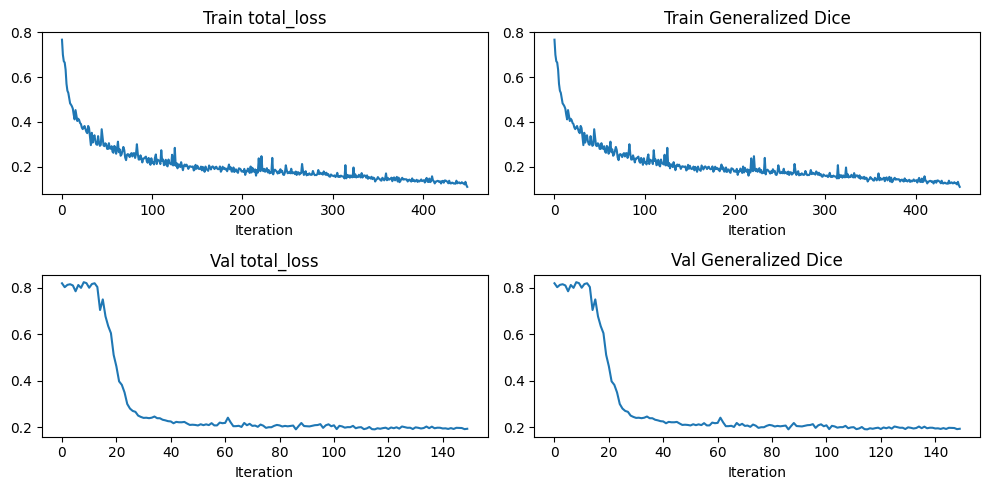

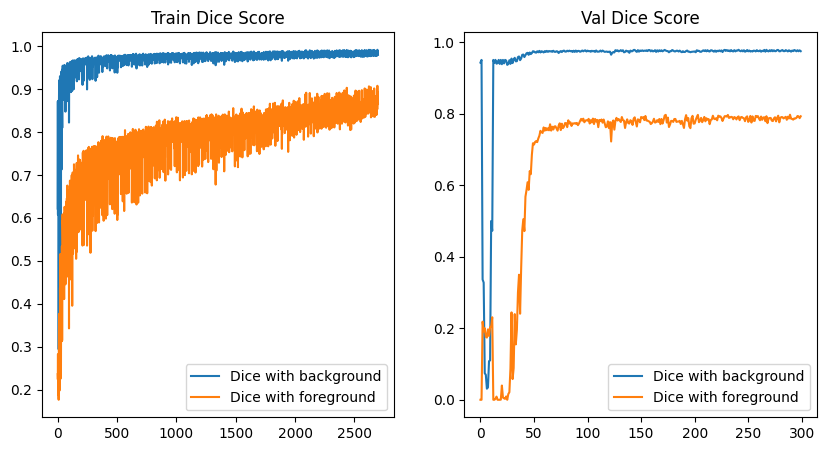

In [ ]:
plot_learning_curve(GDL_train_log, GDL_val_log,
                        reg_loss_name = 'Generalized Dice',
                        with_bl = False,
                        exp_title='GDL')

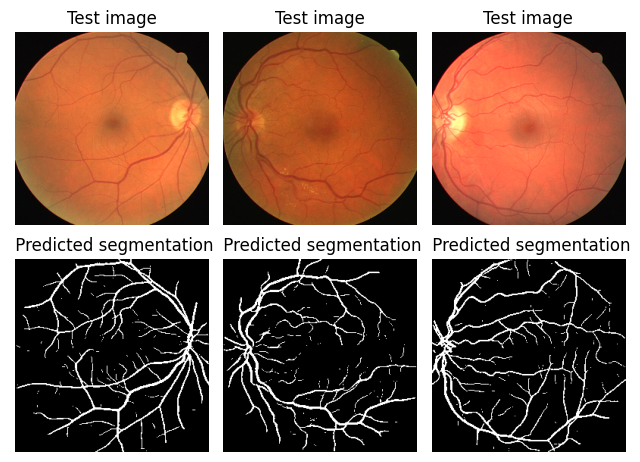

In [ ]:
plot_test_result(train_GDL_net, test_dataset, exp_title='GDL')